In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

from statistics import mean
from scipy import stats

from ast import literal_eval

In [ ]:
def nunique_percent(data: pd.DataFrame) -> pd.Series:
    uniques = data.nunique()
    for i, count in uniques.items():
        percentage = count / data.shape[0] * 100
        print(f'{i}, {count}, {percentage:.2f}%')

def dataframe_info(data: pd.DataFrame) -> None:
    print(data.info())
    print()

    print("NA values per column:")
    print(data.isna().sum())
    print()

    print("Unique values per column:")
    print(nunique_percent(data))
    print()

    print(f'Duplicated Rows: {len(data[data.duplicated()])}')

def safe_convert_to_list(x):
    """Safely convert string representations to lists, trimming spaces."""
    if isinstance(x, str):
        x = x.strip()
        try:
            lst = literal_eval(x)
            return [item.strip() if isinstance(item, str) else item for item in lst]
        except (ValueError, SyntaxError):
            return [item.strip() for item in x.split(',') if item.strip()]
    elif pd.isna(x):
        return []
    return x

def binarize_column(data: pd.DataFrame, col: str):
    mlb = MultiLabelBinarizer()
    data[col] = data[col].apply(safe_convert_to_list)
    binarized_data = mlb.fit_transform(data[col])
    binarized_df = pd.DataFrame(binarized_data, columns=mlb.classes_, index=data.index)

    # Drop original columns
    data = data.drop(col, axis=1)
    data = pd.concat([data, binarized_df], axis=1)

    return data, mlb

def remove_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return dataframe without outliers
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

def remove_outliers_zscore(df, column_name, threshold=3):
    z_scores = stats.zscore(df[column_name])
    return df[abs(z_scores) < threshold]

In [ ]:
df_base_games = pd.read_csv(
    "./info_base_games.csv",
    dtype={"name": "string"},
    converters={
        "appid": lambda x: pd.to_numeric(x, errors="coerce"),
        # 'metacritic': lambda x: pd.to_numeric(x, errors="coerce"),
        "achievements_total": lambda x: pd.to_numeric(x, errors="coerce"),
        "release_date": lambda x: pd.to_datetime(x, errors="coerce"),
    },
)

df_base_games['appid'] = df_base_games['appid'].astype('Int64')
# df_base_games['metacritic'] = df_base_games['metacritic'].astype('Int64')
df_base_games['achievements_total'] = df_base_games['achievements_total'].astype('Int64')

dataframe_info(df_base_games)

<ipython-input-110-65d4abf58e86>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_base_games = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99167 entries, 0 to 99166
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   appid                99166 non-null  Int64         
 1   name                 99149 non-null  string        
 2   metacritic           3019 non-null   object        
 3   steam_achievements   99167 non-null  bool          
 4   steam_trading_cards  99167 non-null  bool          
 5   workshop_support     99167 non-null  bool          
 6   genres               94389 non-null  object        
 7   achievements_total   38114 non-null  Int64         
 8   release_date         78096 non-null  datetime64[ns]
 9   supported_platforms  99167 non-null  object        
dtypes: Int64(2), bool(3), datetime64[ns](1), object(3), string(1)
memory usage: 5.8+ MB
None

NA values per column:
appid                      1
name                      18
metacritic             96148
ste

In [ ]:
df_game_analytics = pd.read_csv(
    "./ms2_gamalytic_steam_games.csv",
    dtype={"publisherClass": "string", "copiesSold": "string"},
)

dataframe_info(df_game_analytics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93338 entries, 0 to 93337
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   steamId         93338 non-null  int64  
 1   price           93338 non-null  float64
 2   copiesSold      93338 non-null  string 
 3   publisherClass  93338 non-null  string 
 4   reviewScore     93338 non-null  int64  
 5   aiContent       0 non-null      float64
dtypes: float64(2), int64(2), string(2)
memory usage: 4.3 MB
None

NA values per column:
steamId               0
price                 0
copiesSold            0
publisherClass        0
reviewScore           0
aiContent         93338
dtype: int64

Unique values per column:
steamId, 93338, 100.00%
price, 350, 0.37%
copiesSold, 4, 0.00%
publisherClass, 4, 0.00%
reviewScore, 99, 0.11%
aiContent, 0, 0.00%
None

Duplicated Rows: 0


In [ ]:
df_dlcs = pd.read_csv(
    "./dlcs.csv",
    dtype={"name": "string"},
    converters={
        "base_appid": lambda x: pd.to_numeric(x, errors="coerce"),
        "dlc_appid": lambda x: pd.to_numeric(x, errors="coerce"),
    },
)

df_dlcs['base_appid'] = df_dlcs['base_appid'].astype('Int64')
df_dlcs['dlc_appid'] = df_dlcs['dlc_appid'].astype('Int64')

dataframe_info(df_dlcs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5445 entries, 0 to 5444
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   base_appid  5444 non-null   Int64 
 1   dlc_appid   5444 non-null   Int64 
 2   name        5445 non-null   string
dtypes: Int64(2), string(1)
memory usage: 138.4 KB
None

NA values per column:
base_appid    1
dlc_appid     1
name          0
dtype: int64

Unique values per column:
base_appid, 5444, 99.98%
dlc_appid, 5444, 99.98%
name, 5443, 99.96%
None

Duplicated Rows: 0


In [ ]:
df_demos = pd.read_csv(
    "./demos.csv",
    dtype={"name": "string"},
    converters={
        "full_game_appid": lambda x: pd.to_numeric(x, errors="coerce"),
        "demo_appid": lambda x: pd.to_numeric(x, errors="coerce"),
    },
)

dataframe_info(df_demos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15449 entries, 0 to 15448
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       15449 non-null  int64  
 1   full_game_appid  15448 non-null  float64
 2   demo_appid       15448 non-null  float64
 3   name             15448 non-null  string 
dtypes: float64(2), int64(1), string(1)
memory usage: 482.9 KB
None

NA values per column:
Unnamed: 0         0
full_game_appid    1
demo_appid         1
name               1
dtype: int64

Unique values per column:
Unnamed: 0, 15449, 100.00%
full_game_appid, 15448, 99.99%
demo_appid, 15448, 99.99%
name, 15425, 99.84%
None

Duplicated Rows: 0


In [ ]:
df = df_game_analytics

# Add demos column
df["demo"] = df["steamId"].isin(df_demos["full_game_appid"])

# Add dlc columns
dlc_counts = df_dlcs.groupby("base_appid").size().reset_index(name="dlc_count")

# Merge tables
df = df.merge(dlc_counts, left_on="steamId", right_on="base_appid", how="left")
df = df.merge(df_base_games, left_on="steamId", right_on="appid", how="inner")

dataframe_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69428 entries, 0 to 69427
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   steamId              69428 non-null  int64         
 1   price                69428 non-null  float64       
 2   copiesSold           69428 non-null  string        
 3   publisherClass       69428 non-null  string        
 4   reviewScore          69428 non-null  int64         
 5   aiContent            0 non-null      float64       
 6   demo                 69428 non-null  bool          
 7   base_appid           3831 non-null   Int64         
 8   dlc_count            3831 non-null   float64       
 9   appid                69428 non-null  Int64         
 10  name                 69428 non-null  string        
 11  metacritic           2933 non-null   object        
 12  steam_achievements   69428 non-null  bool          
 13  steam_trading_cards  69428 non-

In [ ]:
# Fill missing values
df["dlc_count"] = df["dlc_count"].fillna(0).astype(int)
df["achievements_total"] = df["achievements_total"].fillna(0).astype(int)
df["genres"] = df["genres"].fillna("Unknown").astype(str)
df["demo"] = df["demo"].fillna(0).astype(bool)

In [ ]:
df.describe()

,steamId,price,reviewScore,aiContent,base_appid,dlc_count,appid,achievements_total,release_date
count,6.942800e+04,69428.000000,69428.000000,0.0,3831.0,69428.000000,69428.0,69428.000000,68279
mean,1.742130e+06,7.940826,71.903843,NaN,1376808.242495,0.055179,1742130.059745,21.229187,2021-06-04 08:15:02.649423616
min,1.000000e+01,0.000000,0.000000,NaN,2810.0,0.000000,10.0,0.000000,1997-06-30 00:00:00
25%,9.626250e+05,0.990000,60.000000,NaN,771725.0,0.000000,962625.0,0.000000,2019-05-22 00:00:00
50%,1.612815e+06,4.990000,80.000000,NaN,1150440.0,0.000000,1612815.0,3.000000,2021-11-23 00:00:00
75%,2.581562e+06,9.990000,94.000000,NaN,1812320.0,0.000000,2581562.5,20.000000,2024-02-26 00:00:00
max,3.515040e+06,1900.000000,100.000000,NaN,3460800.0,1.000000,3515040.0,5394.000000,2025-10-15 00:00:00
std,9.273455e+05,15.533680,28.682102,NaN,802800.684535,0.228332,927345.450586,176.403615,NaN


In [ ]:
sales_map = {'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}
df['copiesSold'] = df['copiesSold'].map(sales_map)

In [ ]:
# Remove outliers

# df = remove_outliers_iqr(df, 'copiesSold')
# df = remove_outliers_zscore(df, 'copiesSold')

In [ ]:
df.dropna(
    subset=["release_date"],
    inplace=True,
)

df.drop_duplicates(inplace=True)

# Drop irrelevant columns
X, y = (
    df.drop(
        columns=[
            # IDs
            "appid",
            "base_appid",
            "steamId",

            # Useless, Empty, or Zero-variation
            "name",
            "aiContent",
            "metacritic",

            # Target
            "copiesSold",
        ],
        axis=1,
    ),

    # Scale target variable
    df['copiesSold'],
)

In [ ]:
# Feature Encoding
X_transformed = X.copy()

X_transformed['release_date'] = (pd.to_datetime('today') - X_transformed['release_date']).dt.days
# X_transformed["release_date"] = X_transformed["release_date"].clip(lower=0)

X_transformed, encoder_genres = binarize_column(X_transformed, "genres")
X_transformed, encoder_supported_platforms = binarize_column(X_transformed, "supported_platforms")

encoder_publisher_class = OneHotEncoder(sparse_output=False)
onehot_encoded = encoder_publisher_class.fit_transform(X_transformed[["publisherClass"]])
onehot_df = pd.DataFrame(
    onehot_encoded,
    columns=encoder_publisher_class.get_feature_names_out(["publisherClass"]),
    index=X_transformed.index
)

X_transformed = X_transformed.drop("publisherClass", axis=1)
X_transformed = pd.concat([X_transformed, onehot_df], axis=1)

In [ ]:
X_transformed.describe()

,price,reviewScore,dlc_count,achievements_total,release_date,Accounting,Action,Adventure,Animation & Modeling,Audio Production,...,Video Production,Violent,Web Publishing,linux,mac,windows,publisherClass_AA,publisherClass_AAA,publisherClass_Hobbyist,publisherClass_Indie
count,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,...,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000,68279.000000
mean,7.952733,71.948637,0.055947,21.585553,1442.656219,0.000044,0.412191,0.401207,0.000161,0.000088,...,0.000029,0.004452,0.000044,0.201614,0.251893,0.999883,0.031532,0.011761,0.567173,0.389534
std,15.621379,28.487166,0.229821,177.859986,1157.437778,0.006628,0.492233,0.490146,0.012692,0.009374,...,0.005412,0.066577,0.006628,0.401208,0.434103,0.010824,0.174753,0.107807,0.495471,0.487648
min,0.000000,0.000000,0.000000,0.000000,-151.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.990000,60.000000,0.000000,0.000000,446.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.990000,80.000000,0.000000,4.000000,1271.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,9.990000,93.000000,0.000000,20.000000,2187.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1900.000000,100.000000,1.000000,5394.000000,10183.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
dataframe_info(X_transformed)

<class 'pandas.core.frame.DataFrame'>
Index: 68279 entries, 0 to 69427
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    68279 non-null  float64
 1   reviewScore              68279 non-null  int64  
 2   demo                     68279 non-null  bool   
 3   dlc_count                68279 non-null  int64  
 4   steam_achievements       68279 non-null  bool   
 5   steam_trading_cards      68279 non-null  bool   
 6   workshop_support         68279 non-null  bool   
 7   achievements_total       68279 non-null  int64  
 8   release_date             68279 non-null  int64  
 9   Accounting               68279 non-null  int64  
 10  Action                   68279 non-null  int64  
 11  Adventure                68279 non-null  int64  
 12  Animation & Modeling     68279 non-null  int64  
 13  Audio Production         68279 non-null  int64  
 14  Casual                   68

In [ ]:
y.head()

,copiesSold
0,3
1,3
2,3
3,3
4,3


In [ ]:
# Split into initial train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
numeric_features = [
    "release_date",
    "achievements_total",
    "reviewScore",
    "price",
    # "dlc_count",
]

log_features = [
    "release_date",
    "achievements_total",
    "price",
]

col_scale = ColumnTransformer(
    transformers=[
        # ('log', FunctionTransformer(np.log1p), log_features),
        ("num", StandardScaler(), numeric_features),
    ],
    remainder="passthrough",
)

fs = SelectKBest(score_func=f_classif, k=10)

pipelines = [
    (
        "Logistic Regression",
        Pipeline(
            steps=[
                ("scale", col_scale),
                ("feature selecting", fs),
                (
                    "logistic",
                    LogisticRegression(max_iter=1000,
                                       random_state=42,
                    ),
                ),
            ],
        ),
    ),
    (
        "Random Forest",
        Pipeline(
            steps=[
                ("scale", col_scale),
                ("feature selecting", fs),
                (
                    "rand_forest",
                    RandomForestClassifier(
                        random_state=42,
                    ),
                ),
            ],
        ),
    ),
    (
        "Gradient Boosting",
        Pipeline(
            steps=[
                ("scale", col_scale),
                ("feature selecting", fs),
                (
                    "gradient_boost",
                    GradientBoostingClassifier(
                        random_state=42,
                    ),
                ),
            ],
        ),
    ),
    (
        "XGBoost",
        Pipeline(
            steps=[
                ("scale", col_scale),
                ("feature selecting", fs),
                (
                    "XGBoost",
                     XGBClassifier(use_label_encoder=False,
                                   eval_metric='mlogloss',
                                   random_state=42,
                    ),
                ),
            ],
        )
    ),
]

In [ ]:
param_grids = {
    "Logistic Regression": {
        'logistic__C': [0.001, 0.01, 0.1],
        'logistic__penalty': ['l1', 'l2'],
        'logistic__solver': ['saga']
    },
}

tuned_pipeline = []
for model_name, pipeline in pipelines:
    if param_grids.get(model_name) is None:
        tuned_pipeline.append((model_name, pipeline));
        continue

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
    )

    tuned_pipeline.append((model_name, grid_search));

In [ ]:
test_time_history = []
train_time_history = []
test_acc_history = []
model_names = set()

for model_name, pipeline in tuned_pipeline:
    # acc_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

    start_time_train = time.time()
    pipeline.fit(X_train, y_train)
    end_time_train = time.time()

    start_time_test = time.time()
    y_pred = pipeline.predict(X_test)
    end_time_test = time.time()

    print(f"{model_name} Train Time: {end_time_train - start_time_train:.2f} sec")
    print(f"{model_name} Test Time: {end_time_test - start_time_test:.2f} sec")

    # print(f"{model_name} Validation Accuracy       : {mean(acc_scores):.4f}")
    print(f"{model_name} Test Accuracy             : {accuracy_score(y_test, y_pred)}")
    print(f"{model_name} Test classification_report: {classification_report(y_test, y_pred, output_dict=True)}")

    if param_grids.get(model_name):
        print(f"{model_name} Best Params: {pipeline.best_params_}")

    print()

    test_time_history.append(end_time_test - start_time_test)
    train_time_history.append(end_time_train - start_time_train)
    test_acc_history.append(accuracy_score(y_test, y_pred))
    model_names.add(model_name)

Logistic Regression Train Time: 45.99 sec
Logistic Regression Test Time: 0.07 sec
Logistic Regression Test Accuracy             : 0.6304188635032221
Logistic Regression Test classification_report: {'0': {'precision': 0.7465092663112465, 'recall': 0.8488741339491916, 'f1-score': 0.7944076725651763, 'support': 6928.0}, '1': {'precision': 0.4380120152921901, 'recall': 0.44980370162647226, 'f1-score': 0.4438295517432208, 'support': 3566.0}, '2': {'precision': 0.4714881780250348, 'recall': 0.3315403422982885, 'f1-score': 0.38931955211024977, 'support': 2045.0}, '3': {'precision': 0.6578171091445427, 'recall': 0.39928379588182633, 'f1-score': 0.4969359331476323, 'support': 1117.0}, 'accuracy': 0.6304188635032221, 'macro avg': {'precision': 0.5784566421932535, 'recall': 0.5073754934389447, 'f1-score': 0.5311231773915698, 'support': 13656.0}, 'weighted avg': {'precision': 0.6175118686666605, 'recall': 0.6304188635032221, 'f1-score': 0.6178667588195104, 'support': 13656.0}}
Logistic Regression 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:26:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Train Time: 2.41 sec
XGBoost Test Time: 0.16 sec
XGBoost Test Accuracy             : 0.6890011716461628
XGBoost Test classification_report: {'0': {'precision': 0.8398262331838565, 'recall': 0.8650404157043879, 'f1-score': 0.8522468714448237, 'support': 6928.0}, '1': {'precision': 0.5072193758733116, 'recall': 0.6107683679192373, 'f1-score': 0.5541984732824428, 'support': 3566.0}, '2': {'precision': 0.5075239398084815, 'recall': 0.3628361858190709, 'f1-score': 0.4231536926147705, 'support': 2045.0}, '3': {'precision': 0.6492146596858639, 'recall': 0.4440465532676813, 'f1-score': 0.5273790536948432, 'support': 1117.0}, 'accuracy': 0.6890011716461628, 'macro avg': {'precision': 0.6259460521378784, 'recall': 0.5706728806775944, 'f1-score': 0.58924452275922, 'support': 13656.0}, 'weighted avg': {'precision': 0.6876186049823845, 'recall': 0.6890011716461628, 'f1-score': 0.6835874183852719, 'support': 13656.0}}



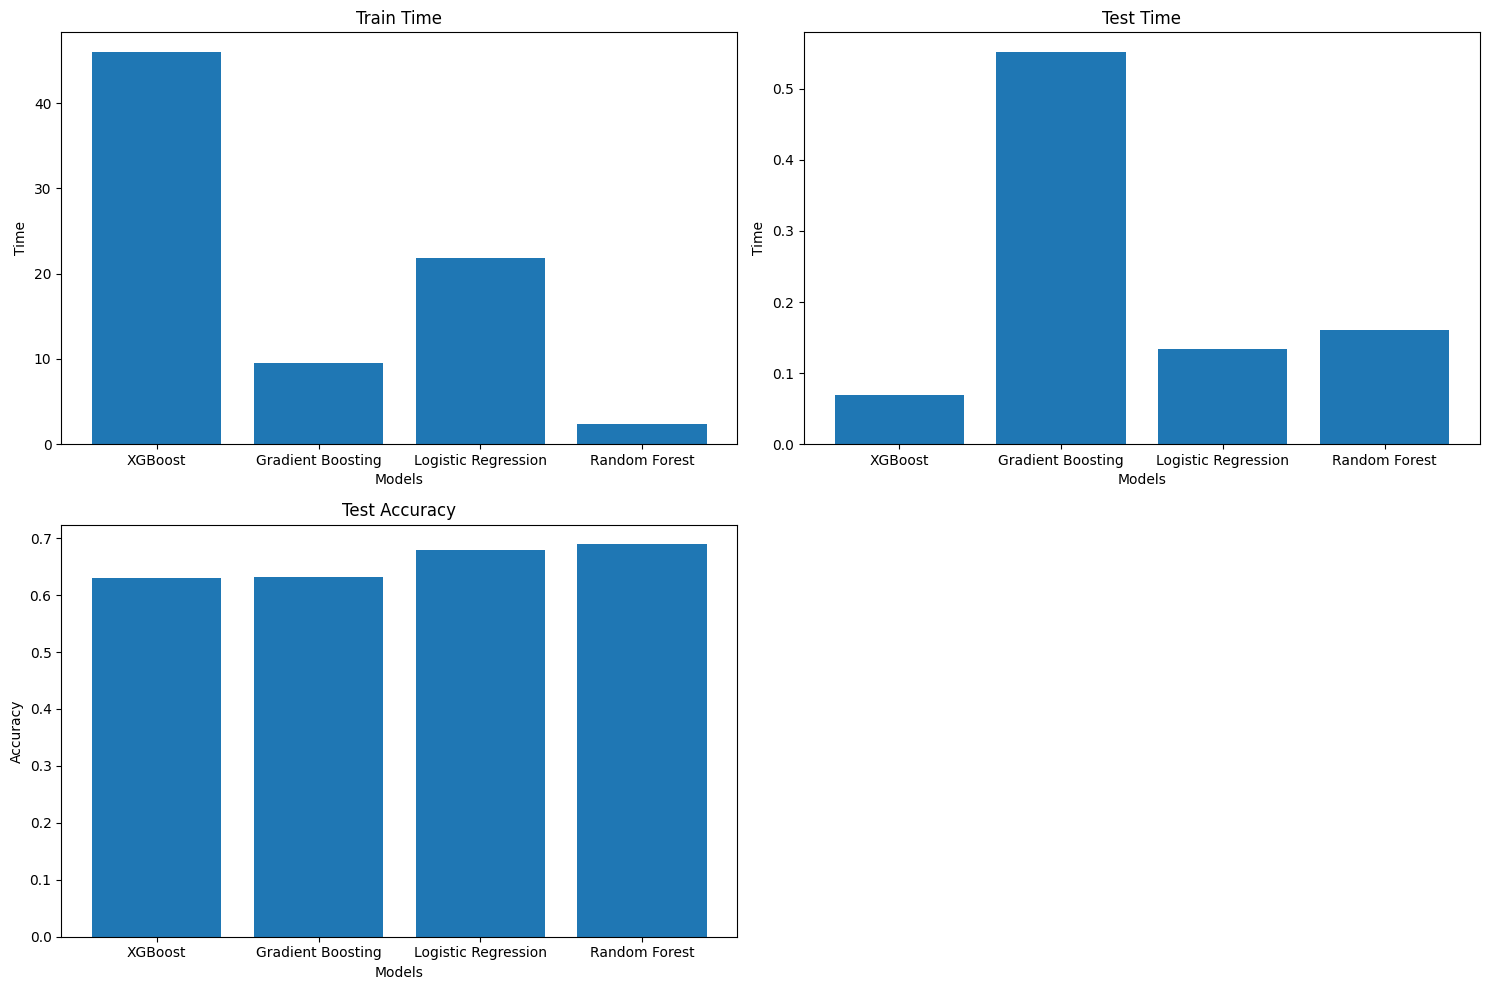

In [ ]:
# Plotting
plt.figure(figsize=(15, 10))

history = [train_time_history, test_time_history, test_acc_history]
for i, metric in enumerate(['Train Time', 'Test Time', 'Test Accuracy']):
    plt.subplot(2, 2, i + 1)
    plt.bar(list(model_names), history[i])
    plt.title(metric)
    plt.xlabel('Models')
    plt.ylabel(metric.split()[1])

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Dump pipeline and encoders
blob = {
  'encoders': {
    'encoder_genres': encoder_genres,
    'encoder_supported_platforms': encoder_supported_platforms,
    'encoder_publisher_class': encoder_publisher_class,
  },
  'models': tuned_pipeline,
}

with open('/content/drive/My Drive/ml_ms2.pkl', 'wb') as f:
    pickle.dump(blob, f)
    print("pickle yum yum!")